<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/4B_AutoML_Deployment_on_GCP_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code book is modified version of original
https://cloud.google.com/ai-platform/docs/getting-started-keras
 # to cater to the classroom instruction format at FourthBrain

 # This provides a solution to transfer data from your Google Drive and run on AI Platform in GCP through GCP. 
 # Please run this code on Colab for complete learning experience.

 1. Ensure your gmail that you connect with Colab has been added to a GCP project
 2. Authenticate Colab to access your Google drive. This surpasses the need for Google authentication

In [ ]:
# Copyright 2019 Google LLC
# Redo for region= US-east1
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting started: Training and prediction with Keras in AI Platform

<img src="https://storage.googleapis.com/cloud-samples-data/ai-platform/census/keras-tensorflow-cmle.png" alt="Keras, TensorFlow, and AI Platform logos" width="300px">

<table align="left">
  <td>
    <a href="https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-keras">
      <img src="https://cloud.google.com/_static/images/cloud/icons/favicons/onecloud/super_cloud.png"
           alt="Google Cloud logo" width="32px"> Read on cloud.google.com
    </a>
  </td>
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/cloudml-samples/blob/master/notebooks/tensorflow/getting-started-keras.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/cloudml-samples/blob/master/notebooks/tensorflow/getting-started-keras.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

This tutorial shows how to train a neural network on AI Platform
using the Keras sequential API and how to serve predictions from that
model.

Keras is a high-level API for building and training deep learning models.
[tf.keras](https://www.tensorflow.org/guide/keras) is TensorFlow’s
implementation of this API.

The first two parts of the tutorial walk through training a model on Cloud
AI Platform using prewritten Keras code, deploying the trained model to
AI Platform, and serving online predictions from the deployed model.

The last part of the tutorial digs into the training code used for this model and ensuring it's compatible with AI Platform. To learn more about building
machine learning models in Keras more generally, read [TensorFlow's Keras
tutorials](https://www.tensorflow.org/tutorials/keras).

### Dataset

This tutorial uses the [United States Census Income
Dataset](https://archive.ics.uci.edu/ml/datasets/census+income) provided by the
[UC Irvine Machine Learning
Repository](https://archive.ics.uci.edu/ml/index.php). This dataset contains
information about people from a 1994 Census database, including age, education,
marital status, occupation, and whether they make more than $50,000 a year.

### Objective

The goal is to train a deep neural network (DNN) using Keras that predicts
whether a person makes more than $50,000 a year (target label) based on other
Census information about the person (features).

This tutorial focuses more on using this model with AI Platform than on
the design of the model itself. However, it's always important to think about
potential problems and unintended consequences when building machine learning
systems. See the [Machine Learning Crash Course exercise about
fairness](https://developers.google.com/machine-learning/crash-course/fairness/programming-exercise)
to learn about sources of bias in the Census dataset, as well as machine
learning fairness more generally.

# Start here
### Setting up your GCP project

**The following steps are required to start a new project. You currently have access to the FourthBrain Project, so step 1 and 2 are NOT applicable for now.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project). 

**For the Live assignment start from here.**

3. [Enable the AI Platform ("Cloud Machine Learning Engine") and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook. 
# **Dont change the settings below for Live assignment.**

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

In [ ]:
PROJECT_ID = "fb-mle-may-21" #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab/Fourth.Brain/GCP/

/content/drive/MyDrive/Colab/Fourth.Brain/GCP


In [ ]:
%ls

4B_AutoML_Deployment_on_GCP_v1.ipynb  cloudml-samples/


### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**
https://cloud.google.com/storage/docs/creating-buckets#storage-create-bucket-console
When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

# Do Not change the settings below for Live Assignment!

In [ ]:
BUCKET_NAME = "rajashekar_ch_bucket" #@param {type:"string"}
REGION = "us-east1" #@param {type:"string"}

# Task 1: Create your Cloud Storage bucket. https://cloud.google.com/storage/docs/creating-buckets

## Give any name to your bitbucket. **Select Region as US-east 1.**
Hit create. Once you run the command below, you should be able to see the bitbucket associated.


In [ ]:
#This will check connection and list the connected data bucket. Ensure Bitbucket created before this.
from google.colab import auth
auth.authenticate_user()
project_id = PROJECT_ID
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://christina4brain21/
gs://claudiab_bucket/
gs://example_fz/
gs://rajashekar_ch_bucket/
gs://tf-bucket-mle-2021-kinga/
gs://tf-bucket-mle-2021-maury/
gs://tf-bucket-mle-2021-sahil/
gs://tf-bucket-mle-may-2021/
gs://tf-bucket-mle-may-2021-evanc/
gs://tf-bucket-mle-may-2021-maf/
gs://tf-bucket-mle-may-2021-pawel/
gs://tf-bucket-mle-may-2021-thursday/
gs://tf-bucket-sy/


## Part 1. Quickstart for training in AI Platform

This section of the tutorial walks you through submitting a training job to Cloud
AI Platform. This job runs sample code that uses Keras to train a deep neural
network on the United States Census data. It outputs the trained model as a
[TensorFlow SavedModel
directory](https://www.tensorflow.org/guide/saved_model#save_and_restore_models)
in your Cloud Storage bucket.

**Details of pre-trained weights: cloudml-samples->tf-keras->trainer**

### Get training code and dependencies

First, download the training code and change the notebook's working directory. The code and data get downloaded to your GDrive:

In [ ]:
# Clone the repository of AI Platform samples
! git clone --depth 1 https://github.com/GoogleCloudPlatform/cloudml-samples

# Set the working directory to the sample code directory
%cd cloudml-samples/census/tf-keras

fatal: destination path 'cloudml-samples' already exists and is not an empty directory.
/content/drive/My Drive/Colab/Fourth.Brain/GCP/cloudml-samples/census/tf-keras


Notice that the training code is structured as a Python package in the
`trainer/` subdirectory:

In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (78.6 kB/s)
Selecting previously unselected package tree.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree

.
├── cloudml-samples
│   ├── census
│   │   ├── customestimator
│   │   │   ├── requirements.txt
│   │   │   ├── scripts
│   │   │   │   └── train-local.sh
│   │   │   └── trainer
│   │   │       ├── __init__.py
│   │   │       ├── model.py
│   │   │       └── task.py
│   │   ├── estimator
│   │   │   ├── constants
│   │   │   │   ├── constants.py
│   │   │   │   └── __init__.py
│   │   │   ├── dataflow_setup.py
│   │   │   ├── preprocessing
│   │   │   │   ├── __init__.py
│   │   │   │   ├── preprocessing_config.ini
│   │   │   │   ├── preprocess.py
│   │   │   │   └── run_preprocessing.py
│   │   │   ├── requirements.txt
│   │   │   ├── scripts
│   │   │   │   └── train-local.sh
│   │   │   ├── setup.py
│   │   │   └── trainer
│   │   │       ├── featurizer.py
│   │   │       ├── __init__.py
│   │   │       ├── input.py
│   │   │       ├── model.py
│   │   │       └── task.py
│   │   ├── hptuning_config.yaml
│   │   ├── keras
│   │   │   ├── preprocess.py
│   │   │   ├── README.md
│

Run the following cell to install Python dependencies needed to train the model locally. When you run the training job in AI Platform,
dependencies are preinstalled based on the [runtime
version](https://cloud.google.com/ml-engine/docs/tensorflow/runtime-version-list)
you choose.

In [ ]:
! pip install -r requirements.txt

### Train your model locally

Before training on AI Platform, train the job locally to verify the file
structure and packaging is correct.

For a complex or resource-intensive job, you
may want to train locally on a small sample of your dataset to verify your code.
Then you can run the job on AI Platform to train on the whole dataset.

This sample runs a relatively quick job on a small dataset, so the local
training and the AI Platform job run the same code on the same data.

Run the following cell to train a model locally:

In [ ]:
!rm -rf local-training-output/keras_export

In [ ]:
# Explicitly tell `gcloud ai-platform local train` to use Python 3 
! gcloud config set ml_engine/local_python $(which python3)

# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  --job-dir local-training-output

Updated property [ml_engine/local_python].
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2021-09-03 23:58:02.887784: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-09-03 23:58:02.890761: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000175000 Hz
2021-09-03 23:58:02.890961: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55564cf51640 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-03 23:58:02.890991: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Train on 254 steps, validate on 1 steps

Epoc

In [ ]:
!ls -ltr local-training-output/keras_export

total 216
drwx------ 2 root root   4096 Sep  3 23:58 variables
-rw------- 1 root root 212386 Sep  3 23:58 saved_model.pb
drwx------ 2 root root   4096 Sep  3 23:58 assets


### Train your model using AI Platform

Next, submit a training job to AI Platform. This runs the training module
in the cloud and exports the trained model to Cloud Storage.

First, give your training job a name and choose a directory within your Cloud
Storage bucket for saving intermediate and output files:

In [ ]:
####ENTER HERE#############################################
JOB_NAME = 'chintalapati2_4B_keras_job' #Pick any name <Lastname_4B_keras_job>
JOB_DIR = 'gs://' + BUCKET_NAME + '/keras-job-dir'
print(JOB_DIR)

gs://rajashekar_ch_bucket/keras-job-dir


Run the following command to package the `trainer/` directory, upload it to the
specified `--job-dir`, and instruct AI Platform to run the
`trainer.task` module from that package.

The `--stream-logs` flag lets you view training logs in the cell below. You can
also see logs and other job details in the GCP Console.

### Hyperparameter tuning
## (This process will take the most time)!!!

You can optionally perform hyperparameter tuning by using the included
`hptuning_config.yaml` configuration file. This file tells AI Platform to tune the batch size and learning rate for training over multiple trials to maximize accuracy.

In this example, the training code uses a [TensorBoard
callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard),
which [creates TensorFlow `Summary`
`Event`s](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter#add_summary)
during training. AI Platform uses these events to track the metric you want to
optimize. Learn more about [hyperparameter tuning in
AI Platform Training](https://cloud.google.com/ml-engine/docs/tensorflow/hyperparameter-tuning-overview).

# While you wait for this step to complete, you can check on GCP console that you job is running!

In [ ]:
! gcloud ai-platform jobs submit training $JOB_NAME \
  --package-path trainer/ \
  --module-name trainer.task \
  --region $REGION \
  --python-version 3.7 \
  --runtime-version 1.15 \
  --job-dir $JOB_DIR \
  --stream-logs

Job [chintalapati2_4B_keras_job] submitted successfully.
INFO	2021-09-04 00:10:07 +0000	service		Validating job requirements...
INFO	2021-09-04 00:10:07 +0000	service		Job creation request has been successfully validated.
INFO	2021-09-04 00:10:08 +0000	service		Job chintalapati2_4B_keras_job is queued.
INFO	2021-09-04 00:10:08 +0000	service		Waiting for job to be provisioned.
INFO	2021-09-04 00:10:10 +0000	service		Waiting for training program to start.
INFO	2021-09-04 00:11:01 +0000	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://rajashekar_ch_bucket/keras-job-dir/packages/7ed4e8c7b8170beebd70612062d2f0b51f17bd53c93ee6c2de541a1de92be680/trainer-0.0.0.tar.gz"],  "python_module": "trainer.task",  "region": "us-east1",  "runtime_version": "1.15",  "job_dir": "gs://rajashekar_ch_bucket/keras-job-dir",  "run_on_raw_vm": true,  "python_version": "3.7"}
WARNING	2021-09-04 00:11:08 +0

# Part 2 (Cloud Deployment). Quickstart for online predictions in AI Platform

This section shows how to use AI Platform and your trained model from Part 1
to predict a person's income bracket from other Census information about them.

### Create model and version resources in AI Platform

To serve online predictions using the model you trained and exported in Part 1,
create a *model* resource in AI Platform and a *version* resource
within it. The version resource is what actually uses your trained model to
serve predictions. This structure lets you adjust and retrain your model many times and
organize all the versions together in AI Platform. Learn more about [models
and
versions](https://cloud.google.com/ml-engine/docs/tensorflow/projects-models-versions-jobs).

First, name and create the model resource:

In [ ]:
############ENTER HERE#########################
MODEL_NAME = "chintalapati1_Keras_model" #<Lastname_Keras_model>

! gcloud ai-platform models create $MODEL_NAME \
  --region $REGION

Using endpoint [https://us-east1-ml.googleapis.com/]
Created ai platform model [projects/fb-mle-may-21/models/chintalapati1_Keras_model].


In [ ]:
!ls

cloudml-samples       local-training-output  requirements.txt  trainer
hptuning_config.yaml  README.md		     scripts


 # You can verify your job completion at the AI Training Dashboard:
 https://console.cloud.google.com/ai-platform/models/

 # Look under jobs and models on the left panel
```

Execute the following command to identify your SavedModel directory and use it to create a model version resource:

In [ ]:
#ENTER HERE#####################
MODEL_VERSION = "v_chintalapati" # Give a unique name <v_Lastname>

# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = !gsutil ls $JOB_DIR/keras_export/
print(KERAS_EXPORT_DIRS)

['gs://rajashekar_ch_bucket/keras-job-dir/keras_export/', 'gs://rajashekar_ch_bucket/keras-job-dir/keras_export/saved_model.pb', 'gs://rajashekar_ch_bucket/keras-job-dir/keras_export/assets/', 'gs://rajashekar_ch_bucket/keras-job-dir/keras_export/variables/']


In [ ]:
# Point to the folder ../keras_export. Your index number may be different that the one here based on how many times you ahve run.
idx=0
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[idx]
print(SAVED_MODEL_PATH)

gs://rajashekar_ch_bucket/keras-job-dir/keras_export/


In [ ]:
print(MODEL_NAME)

chintalapati_Keras_model


In [ ]:
# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --region $REGION \
  --runtime-version 1.15 \
  --python-version 3.7 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

Using endpoint [https://us-east1-ml.googleapis.com/]


# Now you are ready to submit a training job to Google AI platform

# Task 2: Data Preparation for Modeling

To receive valid and useful predictions, you must preprocess input for prediction in the same way that training data was preprocessed. In a production
system, you may want to create a preprocessing pipeline that can be used identically at training time and prediction time.

For this exercise, use the training package's data-loading code to select a random sample from the evaluation data. This data is in the form that was used to evaluate accuracy after each epoch of training, so it can be used to send test predictions without further preprocessing:

In [ ]:
#First, lets review the data and features that are used for classifictaion
from trainer import util

_, _, eval_x, eval_y = util.load_data()

prediction_input = eval_x.sample(20)
prediction_targets = eval_y[prediction_input.index]

prediction_input

,age,workclass,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country
769,1.265886,6,-0.030304,2,3,0,4,-0.144792,-0.217132,-0.437544,38
10675,-0.411611,3,1.136580,2,9,0,4,0.834514,-0.217132,-0.034039,38
10099,-0.192807,3,-0.030304,0,0,1,4,-0.144792,-0.217132,1.176475,38
9688,0.536539,5,-0.419265,2,11,0,4,-0.144792,-0.217132,-0.034039,38
6182,0.171866,3,1.136580,2,3,0,4,0.886847,-0.217132,0.772970,38
8838,-0.046938,3,-1.586149,0,11,1,4,-0.144792,-0.217132,-0.034039,38
400,0.171866,3,1.136580,4,11,1,4,-0.144792,-0.217132,-0.034039,38
3632,-1.140958,3,1.136580,4,3,1,4,-0.144792,-0.217132,-0.034039,38
5487,1.922298,4,-0.419265,0,11,1,4,0.757356,-0.217132,-0.034039,38
15613,-1.505632,3,-0.808226,4,7,3,4,-0.144792,-0.217132,-0.841048,21


Notice that categorical fields, like `occupation`,  have already been converted to integers (with the same mapping that was used for training). Numerical fields, like `age`, have been scaled to a
[z-score](https://developers.google.com/machine-learning/crash-course/representation/cleaning-data). Some fields have been dropped from the original
data. Compare the prediction input with the raw data for the same examples:

In [ ]:
#Now lets review the raw data with all features
import pandas as pd

_, eval_file_path = util.download(util.DATA_DIR)
raw_eval_data = pd.read_csv(eval_file_path,
                            names=util._CSV_COLUMNS,
                            na_values='?')

raw_eval_data.iloc[prediction_input.index]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
769,56,State-gov,133728,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,35,United-States,>50K
10675,33,Private,228931,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,7298,0,40,United-States,>50K
10099,36,Private,149419,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Male,0,0,55,United-States,<=50K
9688,46,Self-emp-not-inc,102869,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,>50K
6182,41,Private,344624,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,7688,0,50,United-States,>50K
8838,38,Private,80680,10th,6,Divorced,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K
400,41,Private,138868,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K
3632,23,Private,124971,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,<=50K
5487,65,Self-emp-inc,116057,HS-grad,9,Divorced,Sales,Not-in-family,White,Female,6723,0,40,United-States,<=50K
15613,18,Private,157193,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,30,Italy,<=50K


Export the prediction input (filtered features only) to a newline-delimited JSON file:

In [ ]:
import json

with open('prediction_input.json', 'w') as json_file:
  for row in prediction_input.values.tolist():
    json.dump(row, json_file)
    json_file.write('\n')

! cat prediction_input.json

[1.265886153588085, 6.0, -0.030303770229214273, 2.0, 3.0, 0.0, 4.0, -0.14479173735784842, -0.21713186390175285, -0.43754385253479555, 38.0]
[-0.4116113873310685, 3.0, 1.1365801932883728, 2.0, 9.0, 0.0, 4.0, 0.8345139648005663, -0.21713186390175285, -0.03403923708700391, 38.0]
[-0.19280736025465722, 3.0, -0.030303770229214273, 0.0, 0.0, 1.0, 4.0, -0.14479173735784842, -0.21713186390175285, 1.176474609256371, 38.0]
[0.5365393966667138, 5.0, -0.4192650914017433, 2.0, 11.0, 0.0, 4.0, -0.14479173735784842, -0.21713186390175285, -0.03403923708700391, 38.0]
[0.17186601820602831, 3.0, 1.1365801932883728, 2.0, 3.0, 0.0, 4.0, 0.8868473744801746, -0.21713186390175285, 0.7729699938085793, 38.0]
[-0.046938008870383005, 3.0, -1.5861490549193304, 0.0, 11.0, 1.0, 4.0, -0.14479173735784842, -0.21713186390175285, -0.03403923708700391, 38.0]
[0.17186601820602831, 3.0, 1.1365801932883728, 4.0, 11.0, 1.0, 4.0, -0.14479173735784842, -0.21713186390175285, -0.03403923708700391, 38.0]
[-1.1409581442524395, 3.0

The `gcloud` command-line tool accepts newline-delimited JSON for online
prediction, and this particular Keras model expects a flat list of
numbers for each input example.

AI Platform requires a different format when you make online prediction requests to the REST API without using the `gcloud` tool. The way you structure
your model may also change how you must format data for prediction. Learn more
about [formatting data for online
prediction](https://cloud.google.com/ml-engine/docs/tensorflow/prediction-overview#prediction_input_data).

### Submit the online prediction request

Use `gcloud` to submit your online prediction request.

In [ ]:
! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --region $REGION \
  --version $MODEL_VERSION \
  --json-instances prediction_input.json

Using endpoint [https://us-east1-ml.googleapis.com/]
[[0.229274571], [0.999999523], [0.070271641], [0.216388911], [1.0], [0.0133795142], [0.185103208], [0.0302113593], [0.212206811], [0.000523209572], [0.158864498], [1.0], [0.460806], [0.241076469], [0.297337472], [9.6321106e-05], [0.347719729], [0.047639735], [0.00380973518], [0.151078835]]


Since the model's last layer uses a [sigmoid function](https://developers.google.com/machine-learning/glossary/#sigmoid_function) for its activation, outputs between 0 and 0.5 represent negative predictions ("<=50K") and outputs between 0.5 and 1 represent positive ones (">50K").

Do the predicted income brackets match the actual ones? Run the following cell
to see the true labels.
# Q: How would you compute classification performance using the output json file above? Enter your answers below.

In [ ]:
# Model gave
model_output = [[0.229274571], [0.999999523], [0.070271641], [0.216388911], [1.0], [0.0133795142], [0.185103208], [0.0302113593], [0.212206811], [0.000523209572], [0.158864498], [1.0], [0.460806], [0.241076469], [0.297337472], [9.6321106e-05], [0.347719729], [0.047639735], [0.00380973518], [0.151078835]]


In [ ]:
[1. if x[0]<=0.5 else 0. for x in model_output]

[1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
prediction_targets

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

## Part 3. Developing the Keras model from scratch

At this point, you have trained a machine learning model on AI Platform, deployed the trained model as a version resource on AI Platform, and received online predictions from the deployment. The next section walks through recreating the Keras code used to train your model. It covers the following parts of developing a machine learning model for use with AI Platform:

* Downloading and preprocessing data
* Designing and training the model
* Visualizing training and exporting the trained model

# Now you will develop  a model from scratch and train on the same data by submitting a fresh job on the AI platform.

### Import libraries and define constants

First, import Python libraries required for training:

In [ ]:
import os
from six.moves import urllib
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf

# Examine software versions
print(__import__('sys').version)
print(tf.__version__)
print(tf.keras.__version__)

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
2.6.0
2.6.0


Then, define some useful constants:

* Information for downloading training and evaluation data
* Information required for Pandas to interpret the data and convert categorical fields into numeric features
* Hyperparameters for training, such as learning rate and batch size

In [ ]:
### For downloading data ###

# Storage directory
DATA_DIR = os.path.join(tempfile.gettempdir(), 'census_data')

# Download options.
DATA_URL = 'https://storage.googleapis.com/cloud-samples-data/ai-platform' \
           '/census/data'
TRAINING_FILE = 'adult.data.csv'
EVAL_FILE = 'adult.test.csv'
TRAINING_URL = '%s/%s' % (DATA_URL, TRAINING_FILE)
EVAL_URL = '%s/%s' % (DATA_URL, EVAL_FILE)

### For interpreting data ###

# These are the features in the dataset.
# Dataset information: https://archive.ics.uci.edu/ml/datasets/census+income
_CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]

_CATEGORICAL_TYPES = {
    'workclass': pd.api.types.CategoricalDtype(categories=[
        'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'
    ]),
    'marital_status': pd.api.types.CategoricalDtype(categories=[
        'Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'
    ]),
    'occupation': pd.api.types.CategoricalDtype([
        'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
        'Sales', 'Tech-support', 'Transport-moving'
    ]),
    'relationship': pd.api.types.CategoricalDtype(categories=[
        'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
        'Wife'
    ]),
    'race': pd.api.types.CategoricalDtype(categories=[
        'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'
    ]),
    'native_country': pd.api.types.CategoricalDtype(categories=[
        'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic',
        'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece',
        'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary',
        'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico',
        'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland',
        'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
        'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'
    ]),
    'income_bracket': pd.api.types.CategoricalDtype(categories=[
        '<=50K', '>50K'
    ])
}

# This is the label (target) we want to predict.
_LABEL_COLUMN = 'income_bracket'

### Hyperparameters for training ###

# This the training batch size
BATCH_SIZE = 128

# This is the number of epochs (passes over the full training data)
NUM_EPOCHS = 20

# Define learning rate.
LEARNING_RATE = .01

### Download and preprocess data

#### Download the data

Next, define functions to download training and evaluation data. These functions also fix minor irregularities in the data's formatting.

In [ ]:
def _download_and_clean_file(filename, url):
    """Downloads data from url, and makes changes to match the CSV format.
  
    The CSVs may use spaces after the comma delimters (non-standard) or include
    rows which do not represent well-formed examples. This function strips out
    some of these problems.
  
    Args:
      filename: filename to save url to
      url: URL of resource to download
    """
    temp_file, _ = urllib.request.urlretrieve(url)
    with tf.io.gfile.GFile(temp_file, 'r') as temp_file_object:
        with tf.io.gfile.GFile(filename, 'w') as file_object:
            for line in temp_file_object:
                line = line.strip()
                line = line.replace(', ', ',')
                if not line or ',' not in line:
                    continue
                if line[-1] == '.':
                    line = line[:-1]
                line += '\n'
                file_object.write(line)
    tf.io.gfile.remove(temp_file)


def download(data_dir):
    """Downloads census data if it is not already present.
  
    Args:
      data_dir: directory where we will access/save the census data
    """
    tf.io.gfile.makedirs(data_dir)

    training_file_path = os.path.join(data_dir, TRAINING_FILE)
    if not tf.io.gfile.exists(training_file_path):
        _download_and_clean_file(training_file_path, TRAINING_URL)

    eval_file_path = os.path.join(data_dir, EVAL_FILE)
    if not tf.io.gfile.exists(eval_file_path):
        _download_and_clean_file(eval_file_path, EVAL_URL)

    return training_file_path, eval_file_path

Use those functions to download the data for training and verify that you have CSV files for training and evaluation: 

In [ ]:
training_file_path, eval_file_path = download(DATA_DIR)

# You should see 2 files: adult.data.csv and adult.test.csv
!ls -l $DATA_DIR

total 5156
-rw-r--r-- 1 root root 3518450 Sep  4 14:47 adult.data.csv
-rw-r--r-- 1 root root 1758573 Sep  4 14:47 adult.test.csv


Next, load these files using Pandas and examine the data:

In [ ]:
# This census data uses the value '?' for fields (column) that are missing data. 
# We use na_values to find ? and set it to NaN values.
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

train_df = pd.read_csv(training_file_path, names=_CSV_COLUMNS, na_values='?')
eval_df = pd.read_csv(eval_file_path, names=_CSV_COLUMNS, na_values='?')

# Here's what the data looks like before we preprocess the data.
train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Preprocess the data

The first preprocessing step removes certain features from the data and
converts categorical features to numerical values for use with Keras.

Learn more about [feature engineering](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering) and [bias in data](https://developers.google.com/machine-learning/crash-course/fairness/types-of-bias).

In [ ]:
UNUSED_COLUMNS = ['fnlwgt', 'education', 'gender']


def preprocess(dataframe):
    """Converts categorical features to numeric. Removes unused columns.
  
    Args:
      dataframe: Pandas dataframe with raw data
  
    Returns:
      Dataframe with preprocessed data
    """
    dataframe = dataframe.drop(columns=UNUSED_COLUMNS)

    # Convert integer valued (numeric) columns to floating point
    numeric_columns = dataframe.select_dtypes(['int64']).columns
    dataframe[numeric_columns] = dataframe[numeric_columns].astype('float32')

    # Convert categorical columns to numeric
    cat_columns = dataframe.select_dtypes(['object']).columns
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.astype(
        _CATEGORICAL_TYPES[x.name]))
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.cat.codes)
    return dataframe


prepped_train_df = preprocess(train_df)
prepped_eval_df = preprocess(eval_df)

Run the following cell to see how preprocessing changed the data. Notice in particular that `income_bracket`, the label that you're training the model to predict, has changed from `<=50K` and `>50K` to `0` and `1`:

In [ ]:
prepped_train_df.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39.0,6,13.0,4,0,1,4,2174.0,0.0,40.0,38,0
1,50.0,5,13.0,2,3,0,4,0.0,0.0,13.0,38,0
2,38.0,3,9.0,0,5,1,4,0.0,0.0,40.0,38,0
3,53.0,3,7.0,2,5,0,2,0.0,0.0,40.0,38,0
4,28.0,3,13.0,2,9,5,2,0.0,0.0,40.0,4,0


Next, separate the data into features ("x") and labels ("y"), and reshape the label arrays into a format for use with `tf.data.Dataset` later:

In [ ]:
# Split train and test data with labels.
# The pop() method will extract (copy) and remove the label column from the dataframe
train_x, train_y = prepped_train_df, prepped_train_df.pop(_LABEL_COLUMN)
eval_x, eval_y = prepped_eval_df, prepped_eval_df.pop(_LABEL_COLUMN)

# Reshape label columns for use with tf.data.Dataset
train_y = np.asarray(train_y).astype('float32').reshape((-1, 1))
eval_y = np.asarray(eval_y).astype('float32').reshape((-1, 1))

Scaling training data so each numerical feature column has a mean of 0 and a standard deviation of 1 [can improve your model](https://developers.google.com/machine-learning/crash-course/representation/cleaning-data).

In a production system, you may want to save the means and standard deviations from your training set and use them to perform an identical transformation on test data at prediction time. For convenience in this exercise, temporarily combine the training and evaluation data to scale all of them:

In [ ]:
def standardize(dataframe):
    """Scales numerical columns using their means and standard deviation to get
    z-scores: the mean of each numerical column becomes 0, and the standard
    deviation becomes 1. This can help the model converge during training.
  
    Args:
      dataframe: Pandas dataframe
  
    Returns:
      Input dataframe with the numerical columns scaled to z-scores
    """
    dtypes = list(zip(dataframe.dtypes.index, map(str, dataframe.dtypes)))
    # Normalize numeric columns.
    for column, dtype in dtypes:
        if dtype == 'float32':
            dataframe[column] -= dataframe[column].mean()
            dataframe[column] /= dataframe[column].std()
    return dataframe


# Join train_x and eval_x to normalize on overall means and standard
# deviations. Then separate them again.
all_x = pd.concat([train_x, eval_x], keys=['train', 'eval'])
all_x = standardize(all_x)
train_x, eval_x = all_x.xs('train'), all_x.xs('eval')

Finally, examine some of your fully preprocessed training data:

In [ ]:
# Verify dataset features
# Note how only the numeric fields (not categorical) have been standardized
train_x.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country
0,0.025997,6,1.136580,4,0,1,4,0.146933,-0.217132,-0.034039,38
1,0.828278,5,1.136580,2,3,0,4,-0.144792,-0.217132,-2.212964,38
2,-0.046938,3,-0.419265,0,5,1,4,-0.144792,-0.217132,-0.034039,38
3,1.047082,3,-1.197188,2,5,0,2,-0.144792,-0.217132,-0.034039,38
4,-0.776285,3,1.136580,2,9,5,2,-0.144792,-0.217132,-0.034039,4


### Design and train the model

#### Create training and validation datasets

Create an input function to convert features and labels into a
[`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets) for training or evaluation:

In [ ]:
def input_fn(features, labels, shuffle, num_epochs, batch_size):
    """Generates an input function to be used for model training.
  
    Args:
      features: numpy array of features used for training or inference
      labels: numpy array of labels for each example
      shuffle: boolean for whether to shuffle the data or not (set True for
        training, False for evaluation)
      num_epochs: number of epochs to provide the data for
      batch_size: batch size for training
  
    Returns:
      A tf.data.Dataset that can provide data to the Keras model for training or
        evaluation
    """
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
eval_x.shape

(16278, 11)

Next, create these training and evaluation datasets.Use the `NUM_EPOCHS`
and `BATCH_SIZE` hyperparameters defined previously to define how the training
dataset provides examples to the model during training. Set up the validation
dataset to provide all its examples in one batch, for a single validation step
at the end of each training epoch.

In [ ]:
# Pass a numpy array by using DataFrame.values
training_dataset = input_fn(features=train_x.values, 
                    labels=train_y, 
                    shuffle=True, 
                    num_epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE)

num_eval_examples = eval_x.shape[0]

# Pass a numpy array by using DataFrame.values
validation_dataset = input_fn(features=eval_x.values, 
                    labels=eval_y, 
                    shuffle=False, 
                    num_epochs=NUM_EPOCHS, 
                    batch_size=num_eval_examples)                

# Design a Keras Model from Scratch. Enter code here..

Design your neural network using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

This deep neural network (DNN) has several hidden layers, and the last layer uses a sigmoid activation function to output a value between 0 and 1:

* The input layer has 100 units using the ReLU activation function.
* The hidden layer has 75 units using the ReLU activation function.
* The hidden layer has 50 units using the ReLU activation function.
* The hidden layer has 25 units using the ReLU activation function.
* The output layer has 1 units using a sigmoid activation function.
* The optimizer uses the binary cross-entropy loss function, which is appropriate for a binary classification problem like this one.

Feel free to change these layers to try to improve the model:

In [ ]:
def create_keras_model(input_dim, learning_rate):
    """Creates Keras Model for Binary Classification.
  
    Args:
      input_dim: How many features the input has
      learning_rate: Learning rate for training
  
    Returns:
      The compiled Keras model (still needs to be trained)
    """
    Dense = tf.keras.layers.Dense
    #################START CODE HERE##############################################
    # Define Keras sequential model with only 5 Dense layers with 100, 75, 50, 25 and 1 neurons each. 
    #All layers except last one has relu activation. 
    #Last layer has sigmoid activation.
    model = tf.keras.Sequential(
      [
          Dense(100, activation=tf.nn.relu, kernel_initializer='uniform',
                  input_shape=(input_dim,)),
          Dense(75, activation=tf.nn.relu),
          Dense(50, activation=tf.nn.relu),
          Dense(25, activation=tf.nn.relu),
          Dense(1, activation=tf.nn.sigmoid),
          #Enter more lines here###############################
      ])
    # Custom Optimizer:
    # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
    optimizer = tf.keras.optimizers.RMSprop(
        lr=learning_rate)

    # Compile Keras model
    model.compile(
        loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Next, create the Keras model object and examine its structure:

In [ ]:
num_train_examples, input_dim = train_x.shape
print('Number of features: {}'.format(input_dim))
print('Number of examples: {}'.format(num_train_examples))

keras_model = create_keras_model(
    input_dim=input_dim,
    learning_rate=LEARNING_RATE)

Number of features: 11
Number of examples: 32561


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
##START CODE HERE#############
keras_model.summary()
#Summarize the Model above##########

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 13,876
Trainable params: 13,876
Non-trainable params: 0
_________________________________________________________________


#### Train and evaluate the model

Define a learning rate decay to encourage model paramaters to make smaller
changes as training goes on:

In [ ]:
# Setup Learning Rate decay.
lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE + 0.02 * (0.5 ** (1 + epoch)),
    verbose=True)

# Setup TensorBoard callback.
tensorboard_cb = tf.keras.callbacks.TensorBoard(
      os.path.join(JOB_DIR, 'keras_tensorboard'),
      histogram_freq=1)

In [ ]:
training_dataset

<BatchDataset shapes: ((None, 11), (None, 1)), types: (tf.float64, tf.float32)>

Finally, train the model. Provide the appropriate `steps_per_epoch` for the
model to train on the entire training dataset (with `BATCH_SIZE` examples per step) during each epoch. And instruct the model to calculate validation
accuracy with one big validation batch at the end of each epoch.


In [ ]:
history = keras_model.fit(training_dataset, 
                          epochs=NUM_EPOCHS, 
                          steps_per_epoch=int(num_train_examples/BATCH_SIZE), 
                          validation_data=validation_dataset, 
                          validation_steps=1, 
                          callbacks=[lr_decay_cb, tensorboard_cb],
                          verbose=1)

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
254/254 [==============================] - 11s 33ms/step - loss: 0.4823 - accuracy: 0.7931 - val_loss: 0.3854 - val_accuracy: 0.8260
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.015.
254/254 [==============================] - 1s 5ms/step - loss: 0.3589 - accuracy: 0.8339 - val_loss: 0.3539 - val_accuracy: 0.8443
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0125.
254/254 [==============================] - 1s 5ms/step - loss: 0.3434 - accuracy: 0.8423 - val_loss: 0.3297 - val_accuracy: 0.8481
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.01125.
254/254 [==============================] - 1s 5ms/step - loss: 0.3373 - accuracy: 0.8448 - val_loss: 0.3300 - val_accuracy: 0.8475
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.010625.
254/254 [==============================] - 1s 5ms/step - loss: 0.3344 - ac

### Visualize training and export the trained model

#### Visualize training

Import `matplotlib` to visualize how the model learned over the training period.

In [ ]:
! pip install matplotlib

from matplotlib import pyplot as plt

%matplotlib inline

Plot the model's loss (binary cross-entropy) and accuracy, as measured at the
end of each training epoch:

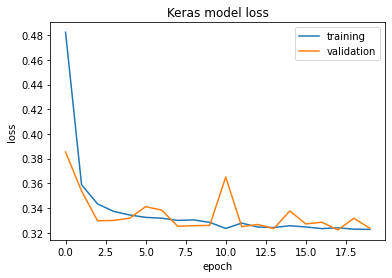

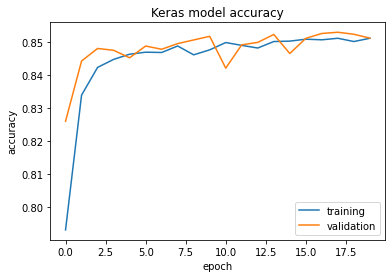

In [ ]:
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [ ]:
%cd /content/drive/My Drive/Colab/Fourth.Brain/GCP/

/content/drive/My Drive/Colab/Fourth.Brain/GCP


In [ ]:
!ls

4B_AutoML_Deployment_on_GCP_v1.ipynb  cloudml-samples


Over time, loss decreases and accuracy increases. But do they converge to a
stable level? Are there big differences between the training and validation
metrics (a sign of overfitting)?

Learn about [how to improve your machine learning
model](https://developers.google.com/machine-learning/crash-course/). Then, feel
free to adjust hyperparameters or the model architecture and train again.

#### Export the model for serving

AI Platform requires when you [create a model version
resource](https://cloud.google.com/ml-engine/docs/tensorflow/deploying-models#create_a_model_version).

Since not all optimizers can be exported to the SavedModel format, you may see
warnings during the export process. As long you successfully export a serving
graph, AI Platform can used the SavedModel to serve predictions.

In [ ]:
# Export the model to a local SavedModel directory 
export_path = tf.compat.v1.keras.experimental.export_saved_model(keras_model, 'keras_export')
print("Model exported to: ", export_path)

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model_experimental.py:117: UserWarning: `tf.keras.experimental.export_saved_model` is deprecatedand will be removed in a future version. Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.
  warnings.warn('`tf.keras.experimental.export_saved_model` is deprecated'
/usr/local/lib/python3.7/dist-packages/keras/backend.py:459: UserWarning: `tf.keras.backend.learning_phase_scope` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.learning_phase_scope` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:S

In [ ]:
%ls

4B_AutoML_Deployment_on_GCP_v1.ipynb  cloudml-samples/  keras_export/


# Task 3: Deploy this model to AI Platform and serve predictions by following the steps from Part 2 (Cloud Deployment). Ensure you know all the steps to train and fetch results for test data.

## Enter your code below.

In [ ]:
MODEL_NAME = "chintalapati2_Keras_model" #<Lastname_Keras_model>

! gcloud ai-platform models create $MODEL_NAME \
  --region $REGION

Using endpoint [https://us-east1-ml.googleapis.com/]
Created ai platform model [projects/fb-mle-may-21/models/chintalapati2_Keras_model].


In [ ]:
MODEL_VERSION = "v_chintalapati" # Give a unique name <v_Lastname>

# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = !gsutil ls $JOB_DIR/keras_export/
print(KERAS_EXPORT_DIRS)

['gs://rajashekar_ch_bucket/keras-job-dir/keras_export/', 'gs://rajashekar_ch_bucket/keras-job-dir/keras_export/saved_model.pb', 'gs://rajashekar_ch_bucket/keras-job-dir/keras_export/assets/', 'gs://rajashekar_ch_bucket/keras-job-dir/keras_export/variables/']


In [ ]:
# Point to the folder ../keras_export. Your index number may be different that the one here based on how many times you ahve run.
idx=0
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[idx]
print(SAVED_MODEL_PATH)

gs://rajashekar_ch_bucket/keras-job-dir/keras_export/


In [ ]:
# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --region $REGION \
  --runtime-version 1.15 \
  --python-version 3.7 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

Using endpoint [https://us-east1-ml.googleapis.com/]


In [59]:
%cd cloudml-samples/census/tf-keras

/content/drive/My Drive/Colab/Fourth.Brain/GCP/cloudml-samples/census/tf-keras/cloudml-samples/census/tf-keras


In [60]:
from trainer import util

_, _, eval_x, eval_y = util.load_data()

prediction_input = eval_x.sample(20)
prediction_targets = eval_y[prediction_input.index]

prediction_targets

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [61]:
import pandas as pd

_, eval_file_path = util.download(util.DATA_DIR)
raw_eval_data = pd.read_csv(eval_file_path,
                            names=util._CSV_COLUMNS,
                            na_values='?')

raw_eval_data.iloc[prediction_input.index]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
645,22,Private,119474,HS-grad,9,Never-married,Sales,Own-child,White,Female,1055,0,25,United-States,<=50K
12807,27,Private,96718,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,39,United-States,<=50K
5197,41,State-gov,29324,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,45,United-States,<=50K
5422,47,Self-emp-not-inc,178319,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1902,42,United-States,>50K
7992,40,Private,41888,Some-college,10,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,2415,70,United-States,>50K
6870,21,Private,191789,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,NaN,<=50K
108,19,Private,289227,Some-college,10,Never-married,Handlers-cleaners,Own-child,Black,Male,0,0,16,United-States,<=50K
982,44,Local-gov,49665,Assoc-voc,11,Divorced,Machine-op-inspct,Unmarried,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
8029,47,Private,341814,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,45,United-States,<=50K
14321,54,Local-gov,113649,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K


In [62]:
import json

with open('prediction_input.json', 'w') as json_file:
  for row in prediction_input.values.tolist():
    json.dump(row, json_file)
    json_file.write('\n')

! cat prediction_input.json

[-1.2138928199445767, 3.0, -0.4192650914017433, 4.0, 11.0, 3.0, 4.0, -0.003223154763010459, -0.21713186390175285, -1.2445530834303788, 38.0]
[-0.8492194414838912, 3.0, -0.4192650914017433, 2.0, 6.0, 0.0, 4.0, -0.14479173735784842, -0.21713186390175285, -0.11474016017656224, 38.0]
[0.17186601820602831, 6.0, -0.4192650914017433, 0.0, 0.0, 4.0, 4.0, -0.14479173735784842, -0.21713186390175285, 0.3694653783607877, 38.0]
[0.609474072358851, 5.0, 1.9145028356334308, 2.0, 9.0, 0.0, 4.0, -0.14479173735784842, 4.5022796885373735, 0.12736260909211275, 38.0]
[0.0989313425138912, 3.0, -0.030303770229214273, 2.0, 13.0, 0.0, 2.0, -0.14479173735784842, 5.775180911671585, 2.386988455599746, 38.0]
[-1.2868274956367138, 3.0, -0.030303770229214273, 4.0, 0.0, 3.0, 4.0, -0.14479173735784842, -0.21713186390175285, -2.4550669297737535, -1.0]
[-1.432696847020988, 3.0, -0.030303770229214273, 4.0, 5.0, 3.0, 2.0, -0.14479173735784842, -0.21713186390175285, -1.9708613912364037, 38.0]
[0.39067004528243965, 1.0, 0.3

In [63]:
! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --region $REGION \
  --version $MODEL_VERSION \
  --json-instances prediction_input.json

Using endpoint [https://us-east1-ml.googleapis.com/]
[[0.000778496265], [0.143446624], [0.0103275776], [0.982282937], [0.990216136], [0.0], [9.19997692e-05], [0.0589633286], [0.669101655], [0.430663079], [0.378354669], [0.758414149], [0.356581926], [0.0192256868], [0.245237529], [0.961015582], [0.000499964051], [0.478549451], [0.726323485], [0.367418528]]


In [64]:
model_output = [[0.000778496265], [0.143446624], [0.0103275776], [0.982282937], [0.990216136], [0.0], [9.19997692e-05], [0.0589633286], [0.669101655], [0.430663079], [0.378354669], [0.758414149], [0.356581926], [0.0192256868], [0.245237529], [0.961015582], [0.000499964051], [0.478549451], [0.726323485], [0.367418528]]

In [66]:
[0. if x[0]<=0.5 else 1. for x in model_output]

[0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0]

In [67]:
prediction_targets

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

## Finally, Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Alternatively, you can clean up individual resources by running the following
commands:

In [ ]:
# Delete model version resource
! gcloud ai-platform versions delete $MODEL_VERSION --quiet --model $MODEL_NAME 

# Delete model resource
! gcloud ai-platform models delete $MODEL_NAME --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r $JOB_DIR

# If the training job is still running, cancel it
! gcloud ai-platform jobs cancel $JOB_NAME --quiet --verbosity critical

Using endpoint [https://us-central1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.versions.delete) NOT_FOUND: Field: name Error: The model resource: "chintalapati_Keras_model" was not found. Please create the model resource first by using 'gcloud ai-platform models create chintalapati_Keras_model'.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: "The model resource: \"chintalapati_Keras_model\" was not found.\
      \ Please create the model resource first by using 'gcloud ai-platform models\
      \ create chintalapati_Keras_model'."
    field: name
Using endpoint [https://us-central1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.models.delete) NOT_FOUND: Field: name Error: The model resource: "chintalapati_Keras_model" was not found. Please create the model resource first by using 'gcloud ai-platform models create chintalapati_Keras_model'.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: "The model re

In [ ]:
!gsutil rm -r gs://$BUCKET_NAME

Removing gs://rajashekar_ch_bucket/...


# Ensure all your data is removed!
Now you know how to use AutoML in GCP!
Congratulations...

## What's next?

* View the [complete training
code](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census/tf-keras) used in this guide, which structures the code to accept custom
hyperparameters as command-line flags.
* Read about [packaging
code](https://cloud.google.com/ml-engine/docs/tensorflow/packaging-trainer) for an AI Platform training job.
* Read about [deploying a
model](https://cloud.google.com/ml-engine/docs/tensorflow/deploying-models) to serve predictions.